In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
import os 
import re

from bids import BIDSLayout
from mne_ari import all_resolutions_inference
import mne

In [2]:
# hard-coded values
BIDS_ROOT = 'bids_dataset'
DERIV_ROOT = os.path.join(BIDS_ROOT, 'derivatives')

In [3]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subjects = layout.get_subjects(scope = 'preprocessing')
subjects.sort()
task = layout.get_tasks()[0]

/home/johnv/anaconda3/envs/agency/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [4]:
def load_subj_data(layout, sub):
    
    evoked_fpath = layout.get(
        scope = 'preprocessing', 
        subject = sub, 
        suffix = 'ave', 
        extension = 'fif.gz', 
        return_type = 'filename')[0]
    evokeds = mne.read_evokeds(evoked_fpath, verbose = False)
    agency = evokeds[0].crop(tmin = -.025).apply_baseline(verbose = False)
    non_agency = evokeds[1].crop(tmin = -.025).apply_baseline(verbose = False)
    diff = mne.combine_evoked(
        [agency, non_agency],
        weights = [1, -1]
    )
    return agency, non_agency, diff

In [5]:
agency = []
non_agency = []
diff = []
for sub in subjects:
    out = load_subj_data(layout, sub)
    agency.append(out[0])
    non_agency.append(out[1])
    diff.append(out[2])
ave_agency = mne.grand_average(agency)
ave_non_agency = mne.grand_average(non_agency)
ave_diff = mne.grand_average(diff)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


No projector specified for this dataset. Please consider the method self.add_proj.


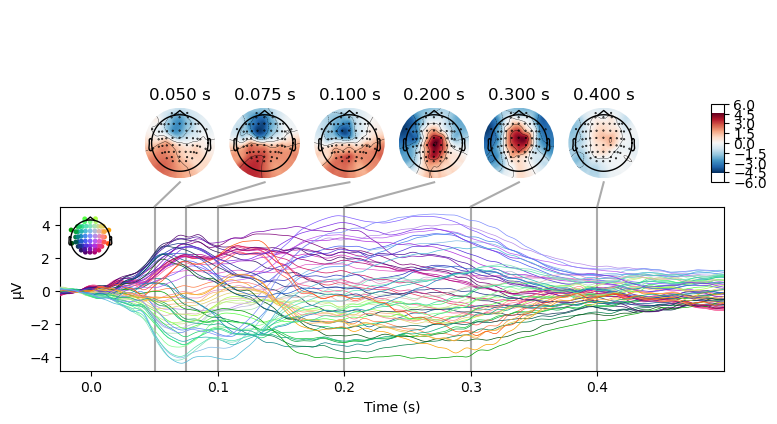

In [6]:
all_trials = mne.combine_evoked([ave_agency, ave_non_agency], weights = 'nave')
all_trials.nave = None
dig = mne.channels.make_standard_montage('standard_1020')
all_trials = all_trials.set_montage(dig)
fig = all_trials.plot_joint([.05, .075, .1, .2, .3, .4], title = ' ')